# EDA

Investigar sobre:

* Hedonic pricing
* Rosen model

In [174]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium


import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder


def mean_absolute_percentage_error(y_pred, y_true):
    y_true = np.where(y_true == 0, 0.0000000001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true))


plt.rcParams['figure.figsize'] = (16,10)

In [155]:
RIDICULOUS_PRICE = 5000000000
RIRIDULOUS_AREA = 10000

train = pd.read_csv("../data/train_data.csv")
train['highPrice'] = np.where(train['valorventa'] > 500000000, "High", "Normal")
train['priceMT2'] = train['valorventa'] / train['area']
train['priceMT2log'] = np.log1p(train['priceMT2'])

train = train[(train['valorventa'] < RIDICULOUS_PRICE) &
              (train['area'] < RIRIDULOUS_AREA)]
train.replace([np.inf], np.nan, inplace=True)
train.dropna(subset=['priceMT2'], inplace=True)

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243669 entries, 0 to 244487
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     243669 non-null  int64  
 1   area                   243669 non-null  float64
 2   ascensor               87394 non-null   float64
 3   balcon                 59938 non-null   float64
 4   banos                  242276 non-null  float64
 5   banoservicio           12202 non-null   float64
 6   conjuntocerrado        243669 non-null  int64  
 7   cuartoservicio         55344 non-null   float64
 8   deposito               107233 non-null  float64
 9   estrato                236346 non-null  float64
 10  estudio                76530 non-null   float64
 11  garajes                212491 non-null  float64
 12  gimnasio               72583 non-null   float64
 13  habitaciones           242962 non-null  float64
 14  halldealcobas          64475 non-nul

In [58]:
train

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud,highPrice,priceMT2
0,1205404,55.0,NaN,NaN,NaN,NaN,0,NaN,1.0,3.0,...,NaN,1.0,50000.0,1.699500e+08,Casa,Venta,4.560965,-74.094889,Normal,3.090000e+06
1,1204371,43.0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,...,NaN,NaN,0.0,9.000000e+07,Casa,Venta,4.576960,-74.100083,Normal,2.093023e+06
2,1125353,360.0,NaN,NaN,NaN,NaN,0,NaN,0.0,3.0,...,NaN,NaN,0.0,1.100000e+09,Casa,Venta,4.575000,-74.101000,High,3.055556e+06
3,1125506,60.0,NaN,NaN,NaN,1.0,0,1.0,0.0,3.0,...,NaN,NaN,0.0,2.600000e+08,Apartamento,Venta,4.575924,-74.108039,Normal,4.333333e+06
4,1204569,72.0,NaN,NaN,NaN,NaN,0,NaN,0.0,2.0,...,NaN,1.0,0.0,1.250000e+08,Casa,Venta,4.559000,-74.097000,Normal,1.736111e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,6262941,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,8.056924e+08,Casa,Venta,4.737393,-74.038282,High,3.428478e+06
244484,6262942,225.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,7.509566e+08,Casa,Venta,4.734240,-74.038518,High,3.337585e+06
244485,6262943,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,7.525618e+08,Casa,Venta,4.736392,-74.040659,High,3.202391e+06
244486,6262944,232.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,7.049425e+08,Casa,Venta,4.737524,-74.040292,High,3.038545e+06


In [47]:
np.quantile(train['area'], 0.99)

nan

In [51]:
train.describe(include='all')

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud,highPrice,priceMT2
count,2.436690e+05,243669.000000,87394.0,59938.0,242276.000000,12202.0,243669.000000,55344.0,107233.000000,236346.000000,...,101978,147768.0,2.155130e+05,2.436690e+05,243669,242900,243669.000000,243669.000000,243669,2.436690e+05
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,NaN,NaN,NaN,2,4,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Exterior,NaN,NaN,NaN,Apartamento,Venta,NaN,NaN,Normal,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79843,NaN,NaN,NaN,186255,231766,NaN,NaN,121917,NaN
mean,6.022807e+05,151.351532,1.0,1.0,2.793628,1.0,0.319856,1.0,0.873388,4.402617,...,NaN,1.0,2.255721e+06,7.654023e+08,NaN,NaN,4.686660,-74.072320,NaN,5.547770e+06
std,4.054395e+05,214.691319,0.0,0.0,1.662693,0.0,0.466422,0.0,0.332540,1.321793,...,NaN,0.0,5.842945e+07,7.999841e+08,NaN,NaN,0.048998,0.038240,NaN,2.573209e+07
min,6.000000e+00,0.000000,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000,0.000000,...,NaN,1.0,0.000000e+00,5.300000e+07,NaN,NaN,3.890660,-74.362167,NaN,0.000000e+00
25%,2.834050e+05,69.000000,1.0,1.0,2.000000,1.0,0.000000,1.0,1.000000,3.000000,...,NaN,1.0,5.000000e+04,3.000000e+08,NaN,NaN,4.657966,-74.090210,NaN,3.586957e+06
50%,5.302930e+05,105.000000,1.0,1.0,3.000000,1.0,0.000000,1.0,1.000000,4.000000,...,NaN,1.0,2.900000e+05,5.000000e+08,NaN,NaN,4.695000,-74.058998,NaN,4.791667e+06
75%,9.068150e+05,183.000000,1.0,1.0,4.000000,1.0,1.000000,1.0,1.000000,6.000000,...,NaN,1.0,6.076000e+05,9.000000e+08,NaN,NaN,4.720134,-74.045471,NaN,6.301370e+06


In [52]:
train['tipoinmueble'].value_counts()

Apartamento    186255
Casa            57414
Name: tipoinmueble, dtype: int64

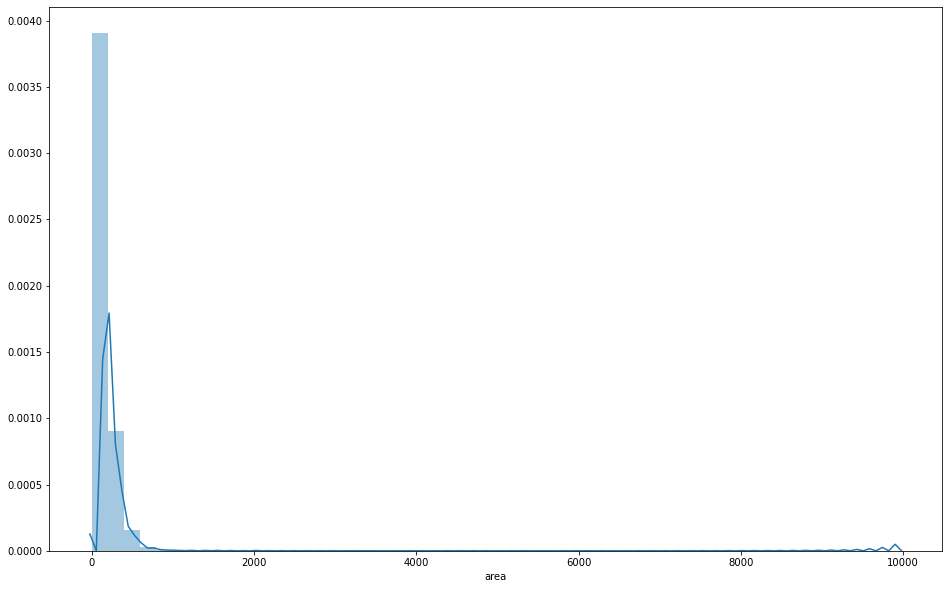

In [53]:
sns.distplot(train['area'])

In [23]:
train[train['valorventa'] < 1000000000]

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,tiempodeconstruido,vigilancia,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud
0,1205404,55.0,NaN,NaN,NaN,NaN,0,NaN,1.0,3.0,...,NaN,NaN,NaN,1.0,50000.0,169950000.0,Casa,Venta,4.560965,-74.094889
1,1204371,43.0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,0.0,90000000.0,Casa,Venta,4.576960,-74.100083
3,1125506,60.0,NaN,NaN,NaN,1.0,0,1.0,0.0,3.0,...,NaN,NaN,NaN,NaN,0.0,260000000.0,Apartamento,Venta,4.575924,-74.108039
4,1204569,72.0,NaN,NaN,NaN,NaN,0,NaN,0.0,2.0,...,NaN,NaN,NaN,1.0,0.0,125000000.0,Casa,Venta,4.559000,-74.097000
5,1161678,126.0,NaN,NaN,NaN,1.0,0,NaN,1.0,3.0,...,NaN,NaN,Exterior,1.0,0.0,600000000.0,Casa,Venta,4.588146,-74.107008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,6262941,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,805692395.0,Casa,Venta,4.737393,-74.038282
244484,6262942,225.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,750956587.0,Casa,Venta,4.734240,-74.038518
244485,6262943,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,752561771.0,Casa,Venta,4.736392,-74.040659
244486,6262944,232.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,704942538.0,Casa,Venta,4.737524,-74.040292


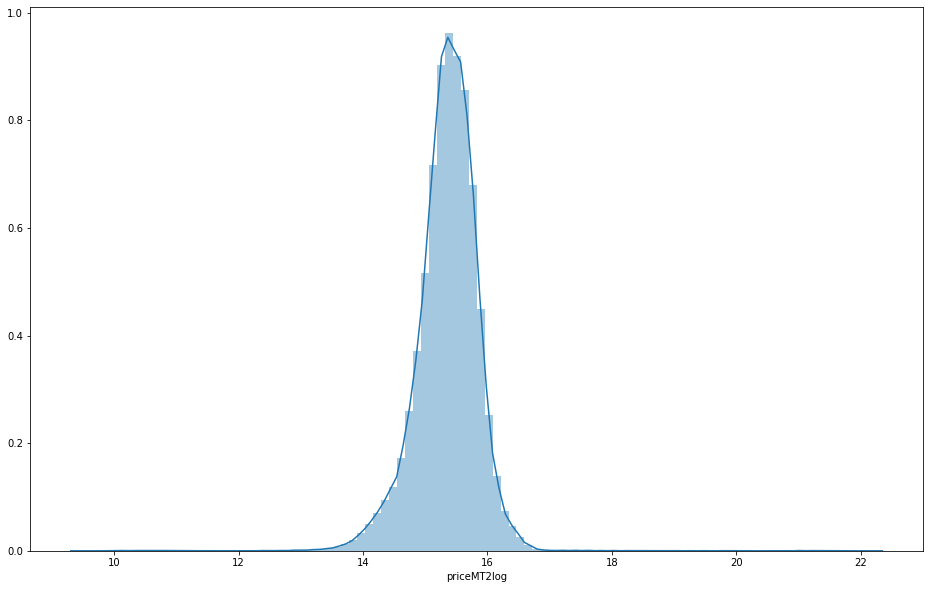

In [140]:
sns.distplot(train['priceMT2log'], bins=100)

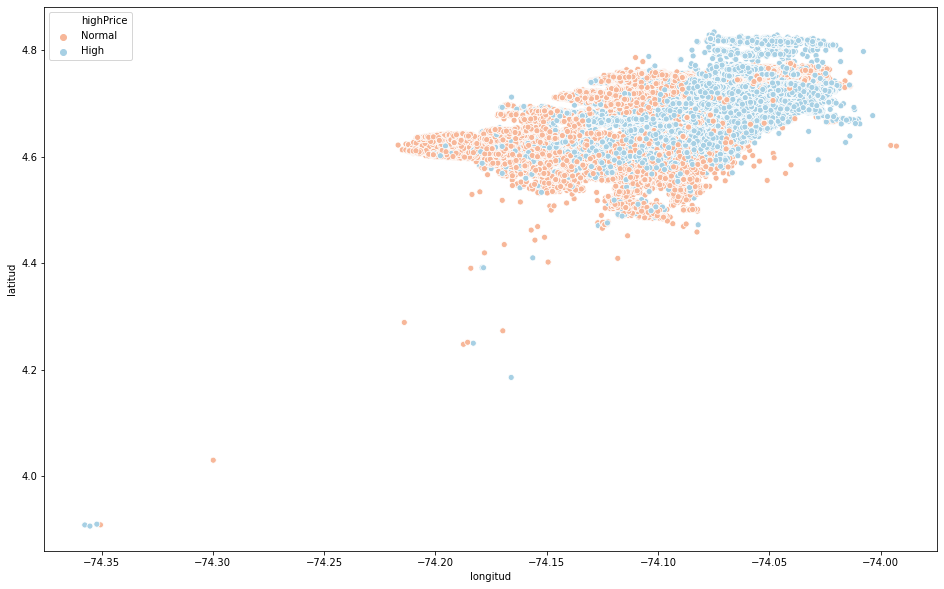

In [139]:
sns.scatterplot(x='longitud',y= 'latitud', data= houses_only, hue = 'highPrice', palette='RdBu')

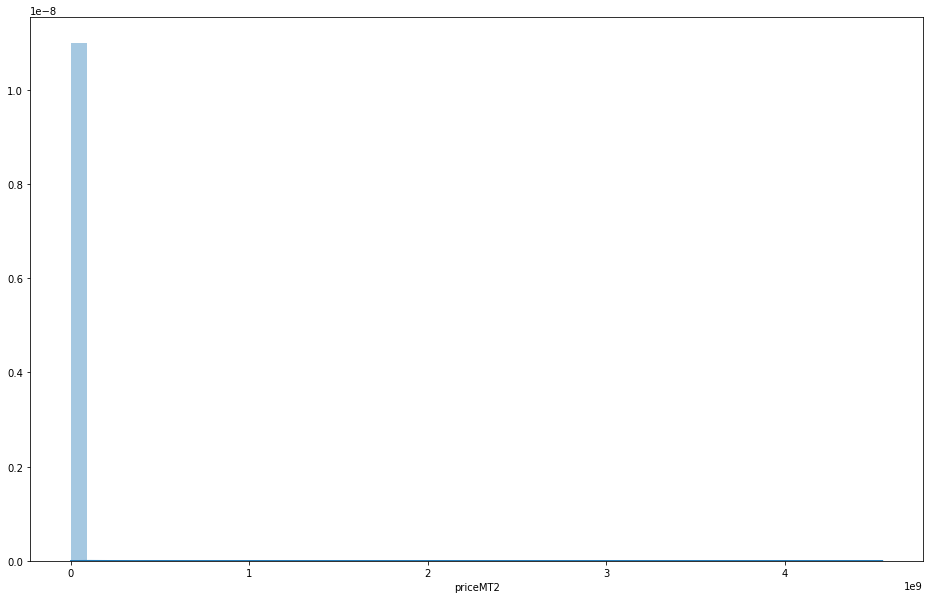

In [56]:
sns.distplot(train['priceMT2'])

In [57]:
train.corr()

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,remodelado,saloncomunal,terraza,vigilancia,zonalavanderia,valoradministracion,valorventa,latitud,longitud,priceMT2
id,1.000000,-0.005696,NaN,NaN,-0.018758,NaN,-0.015098,NaN,-0.422272,-0.145239,...,NaN,NaN,NaN,0.005705,NaN,-0.006409,-0.069425,-0.045630,-0.107528,-0.014714
area,-0.005696,1.000000,NaN,NaN,0.265818,NaN,-0.048374,NaN,-0.022572,0.130365,...,NaN,NaN,NaN,-0.006437,NaN,0.017399,0.415806,0.014952,0.062201,-0.013798
ascensor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balcon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
banos,-0.018758,0.265818,NaN,NaN,1.000000,NaN,-0.051116,NaN,0.019724,0.267767,...,NaN,NaN,NaN,0.009162,NaN,0.014930,0.414353,0.062423,0.161035,0.028517
banoservicio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conjuntocerrado,-0.015098,-0.048374,NaN,NaN,-0.051116,NaN,1.000000,NaN,0.288136,-0.035845,...,NaN,NaN,NaN,0.232505,NaN,0.000497,-0.048604,0.165834,-0.020128,-0.011948
cuartoservicio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deposito,-0.422272,-0.022572,NaN,NaN,0.019724,NaN,0.288136,NaN,1.000000,0.237150,...,NaN,NaN,NaN,0.455879,NaN,0.009553,0.056260,0.116974,0.205792,0.037324
estrato,-0.145239,0.130365,NaN,NaN,0.267767,NaN,-0.035845,NaN,0.237150,1.000000,...,NaN,NaN,NaN,0.059385,NaN,0.024918,0.491055,0.241484,0.634030,0.067290


In [154]:
np.quantile(houses_only['valorventa'],0.99)

5000000000.0

# Baseline model

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243669 entries, 0 to 244487
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     243669 non-null  int64  
 1   area                   243669 non-null  float64
 2   ascensor               87394 non-null   float64
 3   balcon                 59938 non-null   float64
 4   banos                  242276 non-null  float64
 5   banoservicio           12202 non-null   float64
 6   conjuntocerrado        243669 non-null  int64  
 7   cuartoservicio         55344 non-null   float64
 8   deposito               107233 non-null  float64
 9   estrato                236346 non-null  float64
 10  estudio                76530 non-null   float64
 11  garajes                212491 non-null  float64
 12  gimnasio               72583 non-null   float64
 13  habitaciones           242962 non-null  float64
 14  halldealcobas          64475 non-nul

In [164]:
class DataFrameBuilder:
    
    def __init__(self, dataframe, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None
        
    
    def filterRows(self, dataframe):
        return dataframe[dataframe['tipoinmueble'] == casa]
    
    def createVars(self, dataframe):
        
        cat_vars = ['tiempodeconstruido']

        dummified = []
        for var in cat_vars:            
            dummified.append(
                    pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
            )

        dummified = pd.concat(dummified, axis=1)
        dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)
        encoder = OneHotEncoder(handle_unknown = 'ignore')


        for col in dummified.columns:
            features.append(col)
            
        return dataframe
        
    def process(self):
        self.modeling_dataframe = self.createVars(self.original_dataframe)
        return self.modeling_dataframe
    
features = [
            "longitud",
            "latitud",
            "estrato",
            "conjuntocerrado"
]

instance_df = DataFrameBuilder(train)
houses_only = instance_df.process()


y = houses_only['priceMT2log']
X = houses_only[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

136       Entre 10 y 20 años
137       Entre 10 y 20 años
138       Entre 10 y 20 años
140       Entre 10 y 20 años
143       Entre 10 y 20 años
                 ...        
244483        Más de 20 años
244484        Más de 20 años
244485        Más de 20 años
244486        Más de 20 años
244487    Entre 10 y 20 años
Name: tiempodeconstruido, Length: 182137, dtype: object

In [194]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoded = pd.DataFrame(encoder.fit_transform(train.dropna(subset=['tiempodeconstruido'])[['tiempodeconstruido']]).toarray())
encoded.columns = encoder.get_feature_names(['tiempodeconstruido'])
encoded

,tiempodeconstruido_1 a 8 años,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tiempodeconstruido_ntre 0 y 5 años
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
182132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [165]:
X

,longitud,latitud,estrato,conjuntocerrado,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tiempodeconstruido_ntre 0 y 5 años
0,-74.094889,4.560965,3.0,0,0,0,0,0,0,0,0,0,0,0
1,-74.100083,4.576960,NaN,0,0,0,0,0,0,0,0,0,0,0
2,-74.101000,4.575000,3.0,0,0,0,0,0,0,0,0,0,0,0
3,-74.108039,4.575924,3.0,0,0,0,0,0,0,0,0,0,0,0
4,-74.097000,4.559000,2.0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,-74.038282,4.737393,4.0,0,0,0,0,0,0,0,1,0,0,0
244484,-74.038518,4.734240,4.0,0,0,0,0,0,0,0,1,0,0,0
244485,-74.040659,4.736392,4.0,0,0,0,0,0,0,0,1,0,0,0
244486,-74.040292,4.737524,4.0,0,0,0,0,0,0,0,1,0,0,0


In [143]:
houses_only['tiempodeconstruido'].value_counts()

Entre 10 y 20 años    9178
16 a 30 años          8989
Más de 30 años        6768
9 a 15 años           6154
Más de 20 años        4971
1 a 8 años            2597
Entre 5 y 10 años     1743
Entre 0 y 5 años       843
Remodelado             771
Menos de 1 año         558
Name: tiempodeconstruido, dtype: int64

In [166]:
xgb_reg = xgb.XGBRegressor()

In [167]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
xgb_predictions = np.expm1(xgb_reg.predict(X_test)) 
real_price = np.expm1(y_test)

In [169]:
print(f"RMSE: {mean_squared_error(real_price, xgb_predictions)**0.5}")
print(f"MAE {mean_absolute_error(real_price, xgb_predictions)}")
print(f"MAPE: {mean_absolute_percentage_error(xgb_predictions, real_price)} ")

RMSE: 23214914.195316117
MAE 1317530.9504826022
MAPE: 0.2518993703558542 


# Predictions

In [173]:
test = pd.read_csv("../data/test_data.csv")
test['priceMT2'] = test['valorventa'] / test['area']

test_predictions_df = DataFrameBuilder(test).process()
test_predictions_df

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,valorventa,tipoinmueble,tiponegocio,latitud,longitud,priceMT2,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Más de 20 años
0,877392,104.0,NaN,NaN,2.0,NaN,0,NaN,NaN,2.0,...,185000000.0,Casa,Venta,4.711503,-74.132378,1.778846e+06,0,1,0,0
1,201483,144.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,498000000.0,Casa,Venta,4.700643,-74.090080,3.458333e+06,0,0,0,0
2,188674,144.0,NaN,NaN,2.0,NaN,0,NaN,NaN,3.0,...,498000000.0,Casa,Venta,4.700580,-74.090080,3.458333e+06,0,0,0,0
3,1211067,145.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,519000000.0,Casa,Venta,4.702525,-74.091370,3.579310e+06,0,1,0,0
4,883437,145.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,517000000.0,Casa,Venta,4.701413,-74.093254,3.565517e+06,0,1,0,0
5,332550,145.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,514990000.0,Casa,Venta,4.701840,-74.092056,3.551655e+06,0,0,0,0
6,320585,145.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,510000000.0,Casa,Venta,4.699317,-74.092613,3.517241e+06,0,0,0,0
7,776969,145.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,520000000.0,Casa,Venta,4.702012,-74.092400,3.586207e+06,0,1,0,0
8,435344,105.0,NaN,NaN,2.0,NaN,0,NaN,NaN,2.0,...,215000000.0,Casa,Venta,4.710477,-74.132751,2.047619e+06,0,0,0,0
9,1274573,146.0,NaN,NaN,2.0,NaN,0,NaN,1.0,3.0,...,519000000.0,Casa,Venta,4.699274,-74.090851,3.554795e+06,0,1,0,0


In [172]:
test_predictions = np.expm1(xgb_reg.predict(test_predictions_df[features]))
print(f"RMSE: {mean_squared_error(test['priceMT2'], xgb_predictions)**0.5}")
print(f"MAE {mean_absolute_error(test['priceMT2'], xgb_predictions)}")
print(f"MAPE: {mean_absolute_percentage_error(xgb_predictions, test['priceMT2'])} ")

KeyError: "['tiempodeconstruido_ntre 0 y 5 años', 'tiempodeconstruido_Remodelado', 'tiempodeconstruido_Entre 0 y 5 años', 'tiempodeconstruido_Entre 5 y 10 años', 'tiempodeconstruido_Menos de 1 año', 'tiempodeconstruido_Más de 30 años'] not in index"

In [99]:
submission = pd.read_csv("../data/example_submission.csv")
submission['valormt2_predicted'] = test_predictions
submission.head()

,id,valormt2_predicted
0,188674,2338159.50
1,883437,3345390.25
2,320585,3345390.25
3,946955,3345390.25
4,425047,3345390.25


In [ ]:
submission.to_csv("baseline_submission.csv", index=False)